In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
# ! pip install --upgrade pandas yaml tensorflow tensorflow-probability ml-collections jraph

In [7]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dirs

In [15]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"

## My new runs
logging_dir = "/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/"
run_name = "treasured-pyramid-53" 

## Load cluster run

In [16]:
config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [17]:
# Load the dataset

batch_size = 32

train_ds, norm_dict = load_data(
        config.data.dataset,
        config.data.n_features,
        config.data.n_particles,
        batch_size,
        config.seed,
        shuffle=True,
        split="train",
    )

batches = create_input_iter(train_ds)

In [18]:
config.training

batch_size: 16
eval_every_steps: 5000
half_precision: false
log_every_steps: 100
n_train_steps: 301000
p_uncond: 0.0
save_every_steps: 20000
unconditional_dropout: false
warmup_steps: 5000

In [19]:
x, conditioning, mask = next(batches)
x = x[0]
conditioning = conditioning[0]
mask = mask[0]

In [20]:
# Diffusion model
x_mean = tuple(map(float, norm_dict["mean"]))
x_std = tuple(map(float, norm_dict["std"]))
config.data.apply_pbcs = False
box_size = config.data.box_size # if config.data.apply_pbcs else None
unit_cell = tuple(map(tuple, config.data.unit_cell)) if config.data.apply_pbcs else None

norm_dict_input = FrozenDict(
    {
        "x_mean": x_mean,
        "x_std": x_std,
        "box_size": box_size,
        "unit_cell": unit_cell,
    }
)

In [73]:
print("{} devices visible".format(jax.device_count()))

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(
        d_feature=config.data.n_features,
        timesteps=config.vdm.timesteps,
        noise_schedule=config.vdm.noise_schedule,
        noise_scale=1e-4,
        d_t_embedding=config.vdm.d_t_embedding,
        gamma_min=config.vdm.gamma_min,
        gamma_max=config.vdm.gamma_max,
        score=config.score.score,
        score_dict=score_dict,
        embed_context=config.vdm.embed_context,
        d_context_embedding=config.vdm.d_context_embedding,
        n_classes=config.vdm.n_classes,
        use_encdec=config.vdm.use_encdec,
        encoder_dict=encoder_dict,
        decoder_dict=decoder_dict,
        norm_dict=norm_dict_input,
)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# # Training config and state
# schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
# tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
# state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

4 devices visible
Params: 941,481


In [74]:
(loss_diff, loss_klz, loss_recon), params = vdm.init_with_output({"sample": rng, "params": rng, "uncond":rng}, x, conditioning, mask);
loss_diff.mean(), loss_klz.mean(), loss_recon.mean()

(Array(11.495958, dtype=float32),
 Array(0.00016833, dtype=float32),
 Array(33.39897, dtype=float32))

In [75]:
3 * (loss_diff.mean() + loss_klz.mean() + loss_recon.mean())

Array(134.6853, dtype=float32)

In [76]:
mask = np.ones(x.shape[:-1])

In [77]:
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch.mean()

Array(134.6853, dtype=float32)

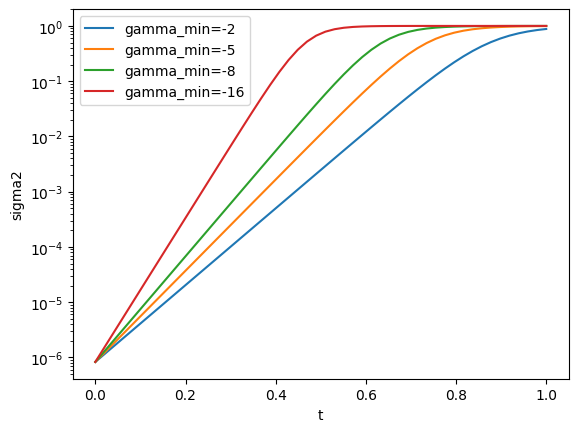

In [58]:
import flax.linen as nn

for gamma_min in [-2, -5, -8, -16]:
        
    # Diffusion model
    vdm = VariationalDiffusionModel(
            d_feature=config.data.n_features,
            timesteps=config.vdm.timesteps,
            noise_schedule="linear",
            noise_scale=config.vdm.noise_scale,
            d_t_embedding=config.vdm.d_t_embedding,
            gamma_min=gamma_min,
            gamma_max=14,
            score=config.score.score,
            score_dict=score_dict,
            embed_context=config.vdm.embed_context,
            d_context_embedding=config.vdm.d_context_embedding,
            n_classes=config.vdm.n_classes,
            use_encdec=config.vdm.use_encdec,
            encoder_dict=encoder_dict,
            decoder_dict=decoder_dict,
            norm_dict=norm_dict_input,
    )

    _, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])
    
    def f(vdm, t):
      return vdm.gammat(t)
    
    t = np.linspace(0, 1)
    sigma2 = nn.sigmoid(-nn.apply(f, vdm)(params, t))
    
    plt.plot(t, sigma2, label=f'gamma_min={gamma_min}')
    plt.yscale("log")
    plt.legend()

    plt.xlabel("t")
    plt.ylabel("sigma2")